In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
# import necessary libraries
from datasets import load_dataset
from transformers import pipeline
from datasets import Dataset
from torch.utils.data import Dataset, ConcatDataset
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer
import torch
import pickle
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
from collections import Counter

## Data Gathering

In [3]:
# load the Empathetic Dialogues dataset using Hugging Face
dataset = load_dataset("empathetic_dialogues")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/empathetic_dialogues.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

The empathetic dataset is already split into the train, validation, and test splits. We first convert these splits into pandas dataframe, then combine these splits into one Dataframe, then shuffle the combined dataset. This is done to avoid any biases in the original splits.

In [4]:
# convert the split datasets to a pandas DataFrames
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

In [5]:
# verify number of conversations in each splits
print(train_df['conv_id'].nunique())
print(val_df['conv_id'].nunique())
print(test_df['conv_id'].nunique())

17844
2763
2542


In [6]:
# combine all datasets
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# verify total number of conversations
print(combined_df['conv_id'].nunique())

23149


In [7]:
# shuffle the combined dataset
# use a random state for reproducibility
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

Now we have our combined and shuffled dataset. Let's perform some data wrangling to see the structure of our dataset and see if we need to do some cleaning

In [7]:
# display the first few rows
print(shuffled_df.head())


               conv_id  utterance_idx      context  \
0  hit:6516_conv:13033              2      annoyed   
1  hit:6320_conv:12640              3    terrified   
2     hit:219_conv:438              3  embarrassed   
3   hit:3288_conv:6576              1    terrified   
4     hit:324_conv:648              3      content   

                                              prompt  speaker_idx  \
0  My friend was supposed to pick me up to go sho...           59   
1  I never could go to sleep as a kid. Too many m...          209   
2  One time i was at a party with friends. I for ...           68   
3                       I am very scary and anxious.           75   
4                I am ok with being average in life.            4   

                                           utterance      selfeval tags  
0  Sorry to hear that. Were they busy or did they...   5|5|5_5|5|5       
1  I always thought there were monsters in the cl...   5|5|5_5|5|5       
2  Yeah when i was going to drive frie

In [8]:
# display information about the dataset
print(shuffled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99646 entries, 0 to 99645
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conv_id        99646 non-null  object
 1   utterance_idx  99646 non-null  int64 
 2   context        99646 non-null  object
 3   prompt         99646 non-null  object
 4   speaker_idx    99646 non-null  int64 
 5   utterance      99646 non-null  object
 6   selfeval       99646 non-null  object
 7   tags           99646 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.1+ MB
None


In [9]:
# display column names
print(shuffled_df.columns)

Index(['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx',
       'utterance', 'selfeval', 'tags'],
      dtype='object')


In [10]:
# check for missing values
print(shuffled_df.isnull().sum())

conv_id          0
utterance_idx    0
context          0
prompt           0
speaker_idx      0
utterance        0
selfeval         0
tags             0
dtype: int64


In [11]:
# get basic statistics of numerical columns
print(shuffled_df.describe())

       utterance_idx   speaker_idx
count   99646.000000  99646.000000
mean        2.716948    279.441232
std         1.342204    208.298285
min         1.000000      0.000000
25%         2.000000    103.000000
50%         3.000000    262.000000
75%         4.000000    413.000000
max         8.000000    853.000000


In [12]:
# check unique values in categorical columns
for column in shuffled_df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in {column}:")
    print(shuffled_df[column].value_counts())


Unique values in conv_id:
conv_id
hit:3952_conv:7905     8
hit:1875_conv:3751     8
hit:2580_conv:5161     8
hit:3126_conv:6253     8
hit:1750_conv:3501     8
                      ..
hit:2444_conv:4888     1
hit:8754_conv:17508    1
hit:826_conv:1653      1
hit:362_conv:724       1
hit:9648_conv:19297    1
Name: count, Length: 23149, dtype: int64

Unique values in context:
context
surprised       5148
excited         3751
annoyed         3552
proud           3500
angry           3457
sad             3446
lonely          3247
grateful        3240
afraid          3222
confident       3176
disgusted       3170
impressed       3166
terrified       3147
anxious         3139
disappointed    3113
hopeful         3098
anticipating    3085
joyful          3070
jealous         3065
guilty          3054
prepared        3036
nostalgic       3029
furious         3025
embarrassed     2949
content         2927
sentimental     2822
devastated      2809
caring          2714
trusting        2603
asham

The dataset is almost clean and just need some few cleaning. We normalize our dataset i.e convert the relevant columns (context, prompt, and utterance) to lowercases, convert the "cooma" in texts to actual COMMA symbol, and also remove extra whitespaces, if any. We create a function for this process and then apply to the relevant columns.

In [8]:
# define a function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = text.replace("_comma_", ",")
    text = ' '.join(text.split())
    return text

In [9]:
# apply the cleaning function to relevant columns
shuffled_df['clean_context'] = shuffled_df['context'].apply(clean_text)
shuffled_df['clean_prompt'] = shuffled_df['prompt'].apply(clean_text)
shuffled_df['clean_utterance'] = shuffled_df['utterance'].apply(clean_text)

In [10]:
print(shuffled_df['conv_id'].nunique())

23149


We group the dataset by conversation ID to maintain the integrity of each dialogue. This grouping is crucial for handling multi-turn conversations effectively. For each conversation, input-output pairs are created for every turn, with the input incorporating the context, prompt, and all previous utterances, and the target being the next utterance in the conversation.




In [11]:
#function for conversation structure
def preprocess_conversations(df):
    processed_data = []

    for conv_id, group in df.groupby('conv_id'):
        context = group['clean_context'].iloc[0]
        prompt = group['clean_prompt'].iloc[0]

        # sort utterances by utterance_idx
        group = group.sort_values('utterance_idx')

        for i in range(1, len(group)):
            current_utterance = group.iloc[i]
            previous_utterances = group.iloc[:i]

            # combine all previous utterances as input
            input_text = ' '.join(previous_utterances['clean_utterance'].tolist())

            processed_data.append({
                'context': context,
                'prompt': prompt,
                'input': input_text,
                'target': current_utterance['clean_utterance'],
                'conv_id': conv_id,
                'utterance_idx': current_utterance['utterance_idx'],
                'speaker_idx': current_utterance['speaker_idx']
            })

    return pd.DataFrame(processed_data)

# apply the preprocessing to your DataFrame
processed_df = preprocess_conversations(shuffled_df)

# print some information about the processed data
print(f"Original dataset size: {len(shuffled_df)}")
print(f"Processed dataset size: {len(processed_df)}")
print("\nSample of processed data:")
print(processed_df.head())

Original dataset size: 99646
Processed dataset size: 76497

Sample of processed data:
       context                                             prompt  \
0       guilty  i felt guilty when i was driving home one nigh...   
1       guilty  i felt guilty when i was driving home one nigh...   
2       guilty  i felt guilty when i was driving home one nigh...   
3       guilty  i felt guilty when i was driving home one nigh...   
4  sentimental  i remember going to the fireworks with my best...   

                                               input  \
0  yeah about 10 years ago i had a horrifying exp...   
1  yeah about 10 years ago i had a horrifying exp...   
2  yeah about 10 years ago i had a horrifying exp...   
3  yeah about 10 years ago i had a horrifying exp...   
4  i remember going to see the fireworks with my ...   

                                              target       conv_id  \
0                       did you suffer any injuries?  hit:0_conv:0   
1  no i wasn't hit. it

In [12]:
# save to pickle for preserving data types
processed_df.to_pickle('/content/drive/My Drive/ITNPBD5 PROJECT/processed_empathetic_dialogues.pkl')

In [ ]:
processed_df.head()

,context,prompt,input,target,conv_id,utterance_idx,speaker_idx
0,guilty,i felt guilty when i was driving home one nigh...,yeah about 10 years ago i had a horrifying exp...,did you suffer any injuries?,hit:0_conv:0,2,1
1,guilty,i felt guilty when i was driving home one nigh...,yeah about 10 years ago i had a horrifying exp...,no i wasn't hit. it turned out they were drunk...,hit:0_conv:0,3,0
2,guilty,i felt guilty when i was driving home one nigh...,yeah about 10 years ago i had a horrifying exp...,why did you feel guilty? people really shouldn...,hit:0_conv:0,4,1
3,guilty,i felt guilty when i was driving home one nigh...,yeah about 10 years ago i had a horrifying exp...,i don't know i was new to driving and hadn't e...,hit:0_conv:0,5,0
4,sentimental,i remember going to the fireworks with my best...,i remember going to see the fireworks with my ...,"was this a friend you were in love with, or ju...",hit:0_conv:1,2,0


In [13]:
print(processed_df['conv_id'].nunique())

23078


In [ ]:
utterance_counts = processed_df.groupby('conv_id').size()
print(utterance_counts.describe())

count    23078.000000
mean         3.314715
std          0.712744
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          7.000000
dtype: float64


In [14]:
print(processed_df['input'].str.len().min())
print(processed_df['target'].str.len().min())

1
1


In [ ]:
print("Raw data sample:")
print(processed_df.iloc[4])

Raw data sample:
context                                                sentimental
prompt           i remember going to the fireworks with my best...
input            i remember going to see the fireworks with my ...
target           was this a friend you were in love with, or ju...
conv_id                                               hit:0_conv:1
utterance_idx                                                    2
speaker_idx                                                      0
Name: 4, dtype: object


## Tokenisation

We set up the tokeniser and add special tokens (context, prompt, response), then save the custom tokeinser for future use

In [14]:
# set up a custom tokeniser
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = '[PAD]'
special_tokens_dict = {
    'pad_token': '[PAD]',
    'additional_special_tokens': ['[CONTEXT]', '[PROMPT]', '[INPUT]', '[TARGET]', '[RESPONSE]']
}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Added {num_added_toks} tokens")
print(f"[RESPONSE] token id: {tokenizer.convert_tokens_to_ids('[RESPONSE]')}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Added 6 tokens
[RESPONSE] token id: 50262


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
# save tokeniser to drive
tokenizer.save_pretrained('/content/drive/MyDrive/ITNPBD5 PROJECT/custom_tokeniser')

# save metadata of tokenizer
import json
tokenizer_meta = {
    'vocab_size': len(tokenizer),
    'special_tokens': tokenizer.special_tokens_map
}
with open('/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer_meta.json', 'w') as f:
    json.dump(tokenizer_meta, f)

We then get the lengths and distributions of tokens. This will help us choose an appropriate maximum length for tokenisation for a gpt tokeniser, which has a maximum length of 1024. We'll analyze the lengths of our context, prompt, input, and target separately, as well as the total length when combined. This will help us understand if we need to truncate or adjust our data to fit within the GPT-2 tokenizer's maximum length of 1024 tokens.

In [17]:
# function to get token lengths
print("Analyzing token lengths...")

def get_tokenized_length(text):
    return len(tokenizer.encode(text, truncation=False))

# analyze lengths for each component
context_lengths = processed_df['context'].apply(get_tokenized_length)
prompt_lengths = processed_df['prompt'].apply(get_tokenized_length)
input_lengths = processed_df['input'].apply(get_tokenized_length)
target_lengths = processed_df['target'].apply(get_tokenized_length)

# calculate total length (including special tokens)
def get_total_length(row):
    full_text = f"[CONTEXT] {row['context']} [PROMPT] {row['prompt']} [INPUT] {row['input']} [TARGET] {row['target']}"
    return get_tokenized_length(full_text)

total_lengths = processed_df.apply(get_total_length, axis=1)

# calculate and print statistics
print("\nContext length statistics:")
print(context_lengths.describe())

print("\nPrompt length statistics:")
print(prompt_lengths.describe())

print("\nInput length statistics:")
print(input_lengths.describe())

print("\nTarget length statistics:")
print(target_lengths.describe())

print("\nTotal sequence length statistics:")
print(total_lengths.describe())

Analyzing token lengths...


Token indices sequence length is longer than the specified maximum sequence length for this model (1696 > 1024). Running this sequence through the model will result in indexing errors



Context length statistics:
count    76497.000000
mean         2.271749
std          0.563464
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: context, dtype: float64

Prompt length statistics:
count    76497.00000
mean        21.12556
std         12.02574
min          1.00000
25%         13.00000
50%         19.00000
75%         26.00000
max        152.00000
Name: prompt, dtype: float64

Input length statistics:
count    76497.000000
mean        37.631763
std         30.467577
min          1.000000
25%         20.000000
50%         32.000000
75%         49.000000
max       1834.000000
Name: input, dtype: float64

Target length statistics:
count    76497.000000
mean        15.604259
std          9.661500
min          1.000000
25%          9.000000
50%         14.000000
75%         20.000000
max        135.000000
Name: target, dtype: float64

Total sequence length statistics:
count    76497.000000
mean        82.278155
s

In [18]:
# Check for sequences exceeding max length
max_length = 1024
over_max = total_lengths[total_lengths > max_length]
print(f"\nNumber of sequences exceeding {max_length} tokens: {len(over_max)}")
print(f"Percentage of sequences exceeding {max_length} tokens: {len(over_max) / len(total_lengths) * 100:.2f}%")


Number of sequences exceeding 1024 tokens: 8
Percentage of sequences exceeding 1024 tokens: 0.01%


We check the distribution of sequence lengths in the dataset to determine the optimal max_length

       input_length  target_length  total_length
count  76497.000000   76497.000000  76497.000000
mean      66.734173      15.604259     82.338432
std       36.029907       9.661500     39.761690
min       10.000000       1.000000     14.000000
25%       45.000000       9.000000     57.000000
50%       60.000000      14.000000     75.000000
75%       81.000000      20.000000     99.000000
max     1881.000000     135.000000   1916.000000


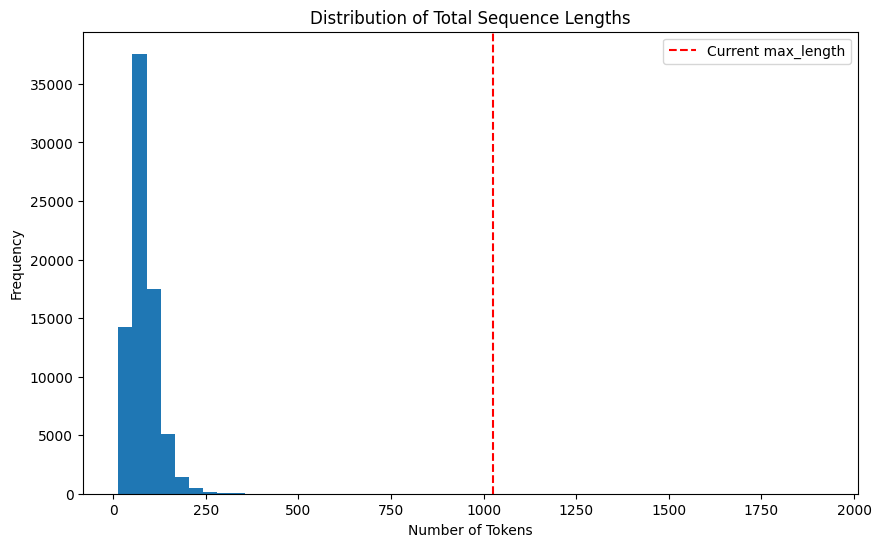

In [20]:
# token length statistics and distributions
def get_lengths(row):
    context = f"[CONTEXT] {row['context']}"
    prompt = f"[PROMPT] {row['prompt']}"
    input_text = f"{context} {prompt} [INPUT] {row['input']} [RESPONSE]"
    target_text = row['target']

    input_length = len(tokenizer.encode(input_text))
    target_length = len(tokenizer.encode(target_text))
    total_length = input_length + target_length

    return pd.Series({'input_length': input_length, 'target_length': target_length, 'total_length': total_length})

length_stats = processed_df.apply(get_lengths, axis=1)

print(length_stats.describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(length_stats['total_length'], bins=50)
plt.title('Distribution of Total Sequence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=1024, color='r', linestyle='--', label='Current max_length')
plt.legend()
plt.show()

We create our tokenised function and set the max_length to 1024 with truncation, since only 0.01% exceed the 1024 token limit for the gpt tokeniser

In [16]:
# tokenise function
def tokenize_function(row, tokenizer, max_length=512):
    context = f"[CONTEXT] {row['context']}"
    prompt = f"[PROMPT] {row['prompt']}"
    input_text = f"{context} {prompt} [INPUT] {row['input']} [RESPONSE]"
    target_text = row['target']

    # tokenise input and target separately
    input_ids = tokenizer.encode(input_text, truncation=True, max_length=max_length, add_special_tokens=False)
    target_ids = tokenizer.encode(target_text, truncation=True, max_length=max_length, add_special_tokens=False)

    # combine input_ids and target_ids, ensuring we don't exceed max_length
    combined_length = len(input_ids) + len(target_ids)
    if combined_length > max_length:
        if len(input_ids) > max_length - len(target_ids):
            input_ids = input_ids[:max_length - len(target_ids)]
        else:
            target_ids = target_ids[:max_length - len(input_ids)]

    # create attention mask
    attention_mask = [1] * len(input_ids) + [1] * len(target_ids)

    # Create labels, setting all tokens before [RESPONSE] to -100
    labels = [-100] * len(input_ids) + target_ids

    # pad sequences if necessary
    padding_length = max_length - len(input_ids) - len(target_ids)
    if padding_length > 0:
        input_ids += [tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        labels += [-100] * padding_length

    return {
        'input_ids': torch.tensor(input_ids),
        'attention_mask': torch.tensor(attention_mask),
        'labels': torch.tensor(labels)
    }

In [17]:
# apply the tokenise function to each row of the DataFrame
def apply_tokenization(df, tokenizer): # Add tokenizer as an argument
    tokenized_data = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Tokenizing data"):
        tokenized = tokenize_function(row, tokenizer)
        tokenized_data.append(tokenized)
    return tokenized_data

# apply tokenisation
tokenized_data = apply_tokenization(processed_df, tokenizer)

Tokenizing data: 100%|██████████| 76497/76497 [01:21<00:00, 943.48it/s]


###A check is implemented to verify that the tokenisation is working properly

In [27]:
# function to check tokenisation
def check_tokenization(tokenized_sample):
    print("Input:", tokenizer.decode(tokenized_sample['input_ids'], skip_special_tokens=False))
    print("Label:", tokenizer.decode(tokenized_sample['labels'][tokenized_sample['labels'] != -100], skip_special_tokens=False))
    print("Label starts at position:", (tokenized_sample['labels'] != -100).nonzero(as_tuple=True)[0][0].item() if (tokenized_sample['labels'] != -100).any() else "No label tokens")
    print("Number of label tokens:", (tokenized_sample['labels'] != -100).sum().item())

# check the first 5 samples
for i, sample in enumerate(tokenized_data[:5]):
    print(f"\nSample {i+1}:")
    check_tokenization(sample)


Sample 1:
Input: [CONTEXT]  guilty  [PROMPT]  i felt guilty when i was driving home one night and a person tried to fly into my lane, and didn't see me. i honked and they swerved back into their lane, slammed on their brakes, and hit the water cones.  [INPUT]  yeah about 10 years ago i had a horrifying experience. it was 100% their fault but they hit the water barrels and survived. they had no injuries but they almost ran me off the road.  [RESPONSE] [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD

A token alignment is implemented to check for the exact alignment of input and label tokens, the positions of the [RESPONSE] token and the first non-masked label token. We must see that all tokens before [RESPONSE] must have labels -100, the first non-masked label should appear immediately after the [RESPONSE] token, and after [RESPONSE], the input tokens and label tokens should match (except for padding)

In [28]:
# function to check token alignment
def detailed_alignment_check(sample, tokenizer):
    input_ids = sample['input_ids']
    labels = sample['labels']

    print("Position | Input Token | Label Token")
    print("-" * 40)

    response_seen = False
    for i, (input_id, label) in enumerate(zip(input_ids, labels)):
        input_token = tokenizer.decode([input_id])
        label_token = tokenizer.decode([label]) if label != -100 else '-100'

        if input_token == '[RESPONSE]':
            response_seen = True

        if response_seen and label != -100 and input_id != label:
            print(f"{i:8d} | {input_token:11s} | {label_token:11s} <-- Mismatch")
        else:
            print(f"{i:8d} | {input_token:11s} | {label_token:11s}")

        if i >= 150:  # print only the first 150 tokens for brevity
            print("...")
            break

    print("\nResponse token position:", (input_ids == tokenizer.convert_tokens_to_ids('[RESPONSE]')).nonzero(as_tuple=True)[0].item())
    # find all non-masked label positions
    non_masked_positions = (labels != -100).nonzero()
    if non_masked_positions.numel() > 0:  # check if there are any non-masked positions
        print("First non-masked label position:", non_masked_positions[0].item()) # print the first one
    else:
        print("No non-masked label positions found.")

# check the first sample
print("Detailed Alignment Check for Sample 1:")
detailed_alignment_check(tokenized_data[2], tokenizer)

Detailed Alignment Check for Sample 1:
Position | Input Token | Label Token
----------------------------------------
       0 | [CONTEXT]   | -100       
       1 |  guilty     | -100       
       2 |             | -100       
       3 | [PROMPT]    | -100       
       4 |  i          | -100       
       5 |  felt       | -100       
       6 |  guilty     | -100       
       7 |  when       | -100       
       8 |  i          | -100       
       9 |  was        | -100       
      10 |  driving    | -100       
      11 |  home       | -100       
      12 |  one        | -100       
      13 |  night      | -100       
      14 |  and        | -100       
      15 |  a          | -100       
      16 |  person     | -100       
      17 |  tried      | -100       
      18 |  to         | -100       
      19 |  fly        | -100       
      20 |  into       | -100       
      21 |  my         | -100       
      22 |  lane       | -100       
      23 | ,           | -100   

In [29]:
# check for the vocubualry size and sizes of special token IDs
print("\nTokenizer details:")
print(f"Vocabulary size: {len(tokenizer)}")
print(f"Special tokens: {tokenizer.special_tokens_map}")
print(f"[CONTEXT] token ID: {tokenizer.convert_tokens_to_ids('[CONTEXT]')}")
print(f"[PROMPT] token ID: {tokenizer.convert_tokens_to_ids('[PROMPT]')}")
print(f"[INPUT] token ID: {tokenizer.convert_tokens_to_ids('[INPUT]')}")
print(f"[TARGET] token ID: {tokenizer.convert_tokens_to_ids('[TARGET]')}")
print(f"[RESPONSE] token ID: {tokenizer.convert_tokens_to_ids('[RESPONSE]')}")



Tokenizer details:
Vocabulary size: 50263
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '[PAD]', 'additional_special_tokens': ['[CONTEXT]', '[PROMPT]', '[INPUT]', '[TARGET]', '[RESPONSE]']}
[CONTEXT] token ID: 50258
[PROMPT] token ID: 50259
[INPUT] token ID: 50260
[TARGET] token ID: 50261
[RESPONSE] token ID: 50262


The dataset is now split into train, validation and test sets. But there needs to be a balanced distribution of the emotional contexts so a stratefied split is performed

In [30]:
# check context distribution before split
def print_context_distribution(df, name):
    context_counts = df['context'].value_counts()
    total = len(df)
    print(f"\n{name} Context Distribution:")
    for context, count in context_counts.items():
        percentage = (count / total) * 100
        print(f"{context}: {count} ({percentage:.2f}%)")

# print overall distribution
print_context_distribution(processed_df, "Overall")


Overall Context Distribution:
surprised: 3948 (5.16%)
excited: 2877 (3.76%)
annoyed: 2728 (3.57%)
proud: 2681 (3.50%)
angry: 2652 (3.47%)
sad: 2648 (3.46%)
lonely: 2488 (3.25%)
grateful: 2483 (3.25%)
afraid: 2472 (3.23%)
confident: 2439 (3.19%)
disgusted: 2433 (3.18%)
impressed: 2418 (3.16%)
terrified: 2415 (3.16%)
anxious: 2407 (3.15%)
disappointed: 2391 (3.13%)
anticipating: 2376 (3.11%)
hopeful: 2374 (3.10%)
jealous: 2359 (3.08%)
joyful: 2345 (3.07%)
guilty: 2344 (3.06%)
furious: 2328 (3.04%)
nostalgic: 2327 (3.04%)
prepared: 2324 (3.04%)
embarrassed: 2257 (2.95%)
content: 2247 (2.94%)
sentimental: 2176 (2.84%)
devastated: 2151 (2.81%)
caring: 2082 (2.72%)
trusting: 2012 (2.63%)
ashamed: 1977 (2.58%)
apprehensive: 1891 (2.47%)
faithful: 1447 (1.89%)


In [18]:
# perform stratified split (80-10-10)
train_val, test = train_test_split(processed_df, test_size=0.1, stratify=processed_df['context'], random_state=42)
train, val = train_test_split(train_val, test_size=0.11111, stratify=train_val['context'], random_state=42)

In [32]:
# print distributions for each set
print_context_distribution(train, "Train")
print_context_distribution(val, "Validation")
print_context_distribution(test, "Test")


Train Context Distribution:
surprised: 3158 (5.16%)
excited: 2301 (3.76%)
annoyed: 2182 (3.57%)
proud: 2145 (3.51%)
angry: 2122 (3.47%)
sad: 2118 (3.46%)
lonely: 1990 (3.25%)
grateful: 1987 (3.25%)
afraid: 1978 (3.23%)
confident: 1951 (3.19%)
disgusted: 1947 (3.18%)
impressed: 1934 (3.16%)
terrified: 1932 (3.16%)
anxious: 1925 (3.15%)
disappointed: 1913 (3.13%)
hopeful: 1900 (3.10%)
anticipating: 1900 (3.10%)
jealous: 1887 (3.08%)
joyful: 1877 (3.07%)
guilty: 1876 (3.07%)
furious: 1862 (3.04%)
nostalgic: 1861 (3.04%)
prepared: 1860 (3.04%)
embarrassed: 1805 (2.95%)
content: 1797 (2.94%)
sentimental: 1741 (2.84%)
devastated: 1721 (2.81%)
caring: 1666 (2.72%)
trusting: 1610 (2.63%)
ashamed: 1581 (2.58%)
apprehensive: 1513 (2.47%)
faithful: 1157 (1.89%)

Validation Context Distribution:
surprised: 395 (5.16%)
excited: 288 (3.76%)
annoyed: 273 (3.57%)
proud: 268 (3.50%)
sad: 265 (3.46%)
angry: 265 (3.46%)
lonely: 249 (3.25%)
grateful: 248 (3.24%)
afraid: 247 (3.23%)
confident: 244 (3.19%)

In [33]:
# print sizes of each set
print(f"\nTrain set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")


Train set size: 61197
Validation set size: 7650
Test set size: 7650


We get the structure of our datasets, which confirms is in a dataframe format

In [34]:
print(type(train))
if isinstance(train, pd.DataFrame):
    print(train.columns)
    print(train.iloc[0])
else:
    print(type(train[0]))
    print(train[0].keys())

<class 'pandas.core.frame.DataFrame'>
Index(['context', 'prompt', 'input', 'target', 'conv_id', 'utterance_idx',
       'speaker_idx'],
      dtype='object')
context                                                  nostalgic
prompt           the skating rink i used to go to as a child is...
input            the skating rink i used to go to as a child is...
target           yea. i wish it was being replaced by something...
conv_id                                        hit:6947_conv:13894
utterance_idx                                                    3
speaker_idx                                                      1
Name: 56385, dtype: object


We create an EmpathyDataset class that takes the dataFrame and tokeniser as inputs, constructs the input text from the context, prompt, and input columns. Then tokenises both the input text and the target text, handles the labeling by setting all tokens before [RESPONSE] to -100 and returns a dictionary with input_ids, attention_mask, and labels

In [19]:
# same tokeniser used in preprocessing
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

class EmpathyDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=1024):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # construct the input text
        input_text = f"[CONTEXT] {row['context']} [PROMPT] {row['prompt']} [INPUT] {row['input']} [RESPONSE]"

        # tokenise input and target
        inputs = self.tokenizer(input_text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(row['target'], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        # remove the batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        labels = labels['input_ids'].squeeze(0)

        # set -100 for non-response tokens in labels
        response_token_id = self.tokenizer.convert_tokens_to_ids('[RESPONSE]')
        response_pos = (inputs['input_ids'] == response_token_id).nonzero(as_tuple=True)[0]
        if len(response_pos) > 0:
            response_pos = response_pos[-1].item()
            labels[:response_pos+1] = -100

        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': labels
        }

    def __len__(self):
        return len(self.dataframe)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# create datasets
train_dataset = EmpathyDataset(train, tokenizer)
val_dataset = EmpathyDataset(val, tokenizer)
test_dataset = EmpathyDataset(test, tokenizer)

In [37]:
# print sample to verify
print("Sample from train_dataset:")
sample = train_dataset[0]
print("Input IDs shape:", sample['input_ids'].shape)
print("Attention Mask shape:", sample['attention_mask'].shape)
print("Labels shape:", sample['labels'].shape)
print("First few tokens:", tokenizer.decode(sample['input_ids'][:10]))

Sample from train_dataset:
Input IDs shape: torch.Size([1024])
Attention Mask shape: torch.Size([1024])
Labels shape: torch.Size([1024])
First few tokens: [CONTEXT] nostalgic [PROMPT]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [41]:
# Save the DataFrames
train.to_pickle('/content/drive/MyDrive/ITNPBD5 PROJECT/train_dataset.pkl')
val.to_pickle('/content/drive/MyDrive/ITNPBD5 PROJECT/val_dataset.pkl')
test.to_pickle('/content/drive/MyDrive/ITNPBD5 PROJECT/test_dataset.pkl')


In [39]:
# save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer')

('/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer/vocab.json',
 '/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer/merges.txt',
 '/content/drive/MyDrive/ITNPBD5 PROJECT/tokenizer/added_tokens.json')

## More Checks
We implement more checks to verify our data is fit for training

In [ ]:
# check to ensure there's balanced distribution of emotions across the datasets.
def print_context_distribution(data, name):
    contexts = [tokenizer.decode(item['input_ids']).split('[CONTEXT]')[1].split('[PROMPT]')[0].strip() for item in data]
    context_counts = Counter(contexts)
    total = len(data)
    print(f"\n{name} Context Distribution:")
    for context, count in context_counts.most_common():
        percentage = (count / total) * 100
        print(f"{context}: {count} ({percentage:.2f}%)")

print_context_distribution(train_dataset, "Train")
print_context_distribution(val_dataset, "Validation")
print_context_distribution(test_dataset, "Test")


Train Context Distribution:
surprised: 4073 (5.11%)
excited: 3016 (3.78%)
annoyed: 2882 (3.62%)
proud: 2805 (3.52%)
sad: 2770 (3.47%)
angry: 2741 (3.44%)
grateful: 2596 (3.26%)
lonely: 2594 (3.25%)
afraid: 2544 (3.19%)
confident: 2534 (3.18%)
terrified: 2531 (3.18%)
impressed: 2515 (3.15%)
anxious: 2512 (3.15%)
disgusted: 2510 (3.15%)
disappointed: 2489 (3.12%)
hopeful: 2471 (3.10%)
prepared: 2467 (3.09%)
anticipating: 2466 (3.09%)
jealous: 2458 (3.08%)
guilty: 2453 (3.08%)
joyful: 2442 (3.06%)
nostalgic: 2439 (3.06%)
furious: 2423 (3.04%)
embarrassed: 2365 (2.97%)
content: 2320 (2.91%)
devastated: 2249 (2.82%)
sentimental: 2249 (2.82%)
caring: 2184 (2.74%)
trusting: 2106 (2.64%)
ashamed: 2038 (2.56%)
apprehensive: 1960 (2.46%)
faithful: 1514 (1.90%)

Validation Context Distribution:
surprised: 560 (5.62%)
angry: 370 (3.71%)
excited: 360 (3.61%)
afraid: 356 (3.57%)
proud: 345 (3.46%)
disgusted: 343 (3.44%)
impressed: 334 (3.35%)
sad: 331 (3.32%)
lonely: 328 (3.29%)
confident: 324 (3.2

In [22]:
# verify the structure of the tokenised datasets
def check_dataset_structure(dataset, name):
    print(f"Checking {name} dataset:")
    print(f"Number of samples: {len(dataset)}")
    print(f"Keys in each sample: {list(dataset[0].keys())}")
    print(f"Shape of input_ids: {dataset[0]['input_ids'].shape}")
    print(f"Shape of attention_mask: {dataset[0]['attention_mask'].shape}")
    print(f"Shape of labels: {dataset[0]['labels'].shape}")
    print("\n")

check_dataset_structure(train_dataset, "Training")
check_dataset_structure(val_dataset, "Validation")
check_dataset_structure(test_dataset, "Test")

Checking Training dataset:
Number of samples: 61197
Keys in each sample: ['input_ids', 'attention_mask', 'labels']
Shape of input_ids: torch.Size([1024])
Shape of attention_mask: torch.Size([1024])
Shape of labels: torch.Size([1024])


Checking Validation dataset:
Number of samples: 7650
Keys in each sample: ['input_ids', 'attention_mask', 'labels']
Shape of input_ids: torch.Size([1024])
Shape of attention_mask: torch.Size([1024])
Shape of labels: torch.Size([1024])


Checking Test dataset:
Number of samples: 7650
Keys in each sample: ['input_ids', 'attention_mask', 'labels']
Shape of input_ids: torch.Size([1024])
Shape of attention_mask: torch.Size([1024])
Shape of labels: torch.Size([1024])




/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [23]:
# check the distribution of token lengths in the datasets.
def check_token_distribution(dataset, name):
    input_lengths = [len(sample['input_ids']) for sample in dataset]
    label_lengths = [(sample['labels'] != -100).sum().item() for sample in dataset]

    print(f"{name} dataset token distribution:")
    print(f"Input lengths - Min: {min(input_lengths)}, Max: {max(input_lengths)}, Avg: {sum(input_lengths)/len(input_lengths):.2f}")
    print(f"Label lengths - Min: {min(label_lengths)}, Max: {max(label_lengths)}, Avg: {sum(label_lengths)/len(label_lengths):.2f}")
    print("\n")

check_token_distribution(train_dataset, "Training")
check_token_distribution(val_dataset, "Validation")
check_token_distribution(test_dataset, "Test")

Training dataset token distribution:
Input lengths - Min: 1024, Max: 1024, Avg: 1024.00
Label lengths - Min: 0, Max: 1024, Avg: 0.12


Validation dataset token distribution:
Input lengths - Min: 1024, Max: 1024, Avg: 1024.00
Label lengths - Min: 0, Max: 1024, Avg: 0.13


Test dataset token distribution:
Input lengths - Min: 1024, Max: 1024, Avg: 1024.00
Label lengths - Min: 0, Max: 0, Avg: 0.00




In [ ]:
# check to ensure special tokens are correctly placed in the inputs.
def check_special_tokens(dataset, name, num_samples=5):
    print(f"Checking special tokens in {name} dataset:")
    for i in range(num_samples):
        sample = dataset[i]
        input_text = tokenizer.decode(sample['input_ids'])
        print(f"Sample {i+1}:")
        print(f"[CONTEXT] position: {input_text.find('[CONTEXT]')}")
        print(f"[PROMPT] position: {input_text.find('[PROMPT]')}")
        print(f"[RESPONSE] position: {input_text.find('[RESPONSE]')}")
        print("\n")

check_special_tokens(train_dataset, "Training")

Checking special tokens in Training dataset:
Sample 1:
[CONTEXT] position: 0
[PROMPT] position: 23
[RESPONSE] position: 80


Sample 2:
[CONTEXT] position: 0
[PROMPT] position: 19
[RESPONSE] position: 96


Sample 3:
[CONTEXT] position: 0
[PROMPT] position: 24
[RESPONSE] position: 189


Sample 4:
[CONTEXT] position: 0
[PROMPT] position: 20
[RESPONSE] position: 189


Sample 5:
[CONTEXT] position: 0
[PROMPT] position: 22
[RESPONSE] position: 214




In [ ]:
# verify that our labels are correctly aligned with the inputs.
def check_label_alignment(dataset, name, num_samples=5):
    print(f"Checking label alignment in {name} dataset:")
    for i in range(num_samples):
        sample = dataset[i]
        input_text = tokenizer.decode(sample['input_ids'])
        label_text = tokenizer.decode(sample['labels'][sample['labels'] != -100])
        response_pos = input_text.find('[RESPONSE]')
        print(f"Sample {i+1}:")
        print(f"Input after [RESPONSE]: {input_text[response_pos+10:response_pos+50]}...")
        print(f"Label text: {label_text[:40]}...")
        print("\n")

check_label_alignment(train_dataset, "Training")

Checking label alignment in Training dataset:
Sample 1:
Input after [RESPONSE]:  [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD...
Label text: he is a legend in the making...


Sample 2:
Input after [RESPONSE]:  [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD...
Label text: watch in the day time with the lights on...


Sample 3:
Input after [RESPONSE]:  [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD...
Label text: i'm sorry to hear that :( it'd be nice i...


Sample 4:
Input after [RESPONSE]:  [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD...
Label text: yea you cant help but feel like a stupid...


Sample 5:
Input after [RESPONSE]:  [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD...
Label text: i've been stuck at a work conference for...


